<a href="https://colab.research.google.com/github/cfoli/Kinematic-Decoding-4-BCI-Control/blob/main/Two_finger_neural_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utility Functions

---



In [1]:

def bin_spikes(spikes, bin_size):

    """
    Bin spikes in time.

    Inputs
    ------
    spikes: numpy array of spikes (neurons x time)

    bin_size: number of time points to pool into a time bin

    Outputs
    -------
    S: numpy array of spike counts (neurons x bins)

    """

    # Get some useful constants.
    [N, n_time_samples] = spikes.shape
    K = int(n_time_samples/bin_size) # number of time bins

    # Count spikes in bins.
    S = np.empty([N, K])
    for k in range(K):
        S[:, k] = np.sum(spikes[:, k*bin_size:(k+1)*bin_size], axis=1)

    return S


# Neural Decoders

---



Standard Kalman Filter

---



In [354]:
import numpy as np
from numpy.linalg import inv
from sklearn.preprocessing import StandardScaler

class KalmanFilter(object):
    """
    Kalman Filter for neural decoding based on the Kording/Wu et al. 2003 framework.

    Adds support for using a fixed initial state (`z0`) and initial uncertainty (`P0`)
    computed from training data. This avoids dependence on ground-truth during inference.

    Attributes
    ----------
    C : float
        Scaling factor for process noise (W). Controls how much to trust the dynamics.

    model : dict
        Contains trained parameters:
            - A: State transition matrix
            - W: Process noise covariance
            - H: Observation matrix
            - Q: Observation noise covariance
            - z0: Initial state mean (column vector)
            - P0: Initial state covariance matrix
    """

    def __init__(self, C=1, O=1):
        """
        Initializes the Kalman filter object.

        Parameters
        ----------
        C : float, optional (default=1)
            Scaling factor for process noise (W). Increasing C reduces the weight of
            the dynamics (A) during filtering.
        O : int, optional (default=1)
            Autoregressive model order for the state model (must be >= 1). O controls how many past time steps are used to predict the next state. A larger O models long-term temporal dependencies.
        """
        self.C = C
        assert O >= 1, "Autoregressive order O must be >= 1"
        self.O = O

        self.data_preprocessor = StandardScaler() # Z-score neural data
        self.targ_transformer  = StandardScaler(with_std=False) # Zero-center target data

    def fit(self, X_kf_train, y_train):
        """
        Train the Kalman Filter model using paired neural and behavioral data.

        Parameters
        ----------
        X_kf_train : ndarray of shape [n_samples, n_neurons]
            Neural features (observations).

        y_train : ndarray of shape [n_samples, n_outputs]
            Behavioral variables (true hidden states).
        """
        X_kf_train = self.data_preprocessor.fit_transform(X_kf_train)
        y_train    = self.targ_transformer.fit_transform(y_train)

        X  = np.matrix(y_train.T)  # Hidden state (e.g., kinematics)
        Z  = np.matrix(X_kf_train.T)  # Observations (e.g., spikes)
        nt = X.shape[1]  # Number of time steps

        # Fit state transition matrix (A) and process noise (W)
        o = self.O  # autoregressive model order
        X2 = X[:, o:]
        X1 = X[:, 0:nt - o]
        A = X2 @ X1.T @ inv(X1 @ X1.T)
        W = (X2 - A @ X1) @ (X2 - A @ X1).T / (nt - o) / self.C

        # Fit observation matrix (H) and observation noise (Q)
        H = Z @ X.T @ inv(X @ X.T)
        Q = (Z - H @ X) @ (Z - H @ X).T / nt

        # Initial state: use first state from training
        z0 = np.asarray(X[:, 0]).flatten()  # Initial state vector

        # Initial uncertainty: small identity matrix
        P0 = np.eye(X.shape[0]) * 1e-3

        # Store model parameters
        self.model = {
            'A': A,
            'W': W,
            'H': H,
            'Q': Q,
            'z0': z0,
            'P0': P0
        }

    def predict(self, X_kf_test):
        """
        Predict hidden states from neural observations using the trained Kalman Filter.

        This method initializes the filter with the precomputed `z0` and `P0` from training.

        Parameters
        ----------
        X_kf_test : ndarray of shape [n_samples, n_neurons]
            Neural features to decode.

        Returns
        -------
        y_pred : ndarray of shape [n_samples, n_outputs]
            Estimated hidden states (e.g., positions or velocities).
        """

        X_kf_test = self.data_preprocessor.transform(X_kf_test)

        # Load model parameters
        A = self.model['A']
        W = self.model['W']
        H = self.model['H']
        Q = self.model['Q']
        z0 = self.model['z0']
        P0 = self.model['P0']

        Z = np.matrix(X_kf_test.T)
        num_states = A.shape[0]
        num_timesteps = Z.shape[1]

        # Initialize state and covariance
        states = np.empty((num_states, num_timesteps))
        P = np.matrix(P0)
        state = np.matrix(z0).T  # Ensure column vector

        # Set initial state
        states[:, 0] = np.asarray(state).flatten()

        # Kalman filtering loop
        for t in range(num_timesteps - 1):
            # Predict next state
            P_m = A @ P @ A.T + W
            state_m = A @ state

            # Kalman gain
            K = P_m @ H.T @ np.linalg.inv(H @ P_m @ H.T + Q)

            # Update state
            state = state_m + K @ (Z[:, t + 1] - H @ state_m)
            P = (np.eye(num_states) - K @ H) @ P_m

            # Store prediction
            states[:, t + 1] = np.asarray(state).flatten()

        # ----------- Aliases -----------
        # H is sometimes denoted as C in literature, and represents the transformation that converts kinematics to neural features
        # Z is sometimes denoted y and represents the observed neural features
        # -------------------------------

        # Return predicted states (time x features)...after undoing zero-centering
        return self.targ_transformer.inverse_transform(states.T)


ReFIT-Kalman Filter

---





In [278]:
import numpy as np
from numpy.linalg import inv

class ReFITKalmanFilter(KalmanFilter):
    """
    ReFIT Kalman Filter (Gilja et al., 2012) using intention-aligned training and optional
    position feedback correction during decoding.

    This subclass extends KalmanFilter_zeroInit by:

    1. Modifying the training targets to reflect intended velocities based on position and target.
    2. Supporting velocity reorientation methods: "flip", "rotate", or "both".
    3. Allowing optional velocity zeroing when inside the target.

    Parameters
    ----------
    C : float
        Scaling factor for process noise in KalmanFilter_zeroInit.
    alpha : float
        Velocity blending factor during training (used for rotation).
    velocity_rot_method : str
        Velocity correction method: 'flip', 'rotate', or 'both'.
    zero_vel_on_target_TF : bool
        If True, zero velocity when inside target radius.
    """
    def __init__(self, C=1, alpha=0.8, velocity_rot_method="flip", zero_vel_on_target_TF=False):
        super().__init__(C)
        self.alpha = alpha
        self.velocity_rot_method = velocity_rot_method.lower()
        self.zero_vel_on_target_TF = zero_vel_on_target_TF

    def _compute_flipped_velocity(self, pos, vel, targ, targsize):
        """Flip velocity if moving away from the target."""
        v_flip = vel.copy()
        T, D = pos.shape
        for t in range(T):
            for d in range(D):
                if targ[t, d] == -1:
                    continue
                dist = pos[t, d] - targ[t, d]
                hit = abs(dist) < targsize
                if self.zero_vel_on_target_TF and hit:
                    v_flip[t, d] = 0
                elif (dist < 0 and v_flip[t, d] < 0) or (dist > 0 and v_flip[t, d] > 0):
                    v_flip[t, d] *= -1
        return v_flip

    def _compute_rotated_velocity(self, pos, vel, targ, targsize):
        """Rotate velocity to point toward the target direction."""
        v_rot = vel.copy()
        T, D = pos.shape
        targ = targ[:, :D]  # Only keep position dimensions

        for t in range(T):
            good_dims = targ[t] != -1
            if not np.any(good_dims):
                continue
            vec_to_target = targ[t, good_dims] - pos[t, good_dims]
            norm_vec = np.linalg.norm(vec_to_target)
            if norm_vec > 1e-5:
                speed = np.linalg.norm(v_rot[t, good_dims])
                v_rot[t, good_dims] = (vec_to_target / norm_vec) * speed
                if self.zero_vel_on_target_TF:
                    hit_mask = np.zeros_like(good_dims)
                    hit_mask[good_dims] = np.abs(pos[t, good_dims] - targ[t, good_dims]) < targsize
                    v_rot[t, hit_mask] = 0
        return v_rot

    def compute_intended_trajectory(self, y_train, targets, targsize):
        """
        Modifies training trajectories to align velocity with target using selected strategy.

        Parameters
        ----------
        y_train : ndarray of shape [T, 2*D]
            Original training behavior data [position, velocity].
        targets : ndarray of shape [T, D]
            Target positions.
        targsize : scalar
            Target size threshold for each time point.

        Returns
        -------
        y_refit : ndarray of shape [T, 2*D]
            Modified training data with position and reoriented velocity.
        """
        T, total_dims = y_train.shape
        D = total_dims // 2
        pos = y_train[:, :D]
        vel = y_train[:, D:]

        if self.velocity_rot_method == "rotate":
            vel_new = self._compute_rotated_velocity(pos, vel, targets, targsize)
            pos_new = pos
        elif self.velocity_rot_method == "flip":
            vel_new = self._compute_flipped_velocity(pos, vel, targets, targsize)
            pos_new = pos

        else:
            raise ValueError("Invalid velocity_rot_method. Must be 'flip' or 'rotate'.")

        return np.hstack([pos_new, vel_new])

    def fit(self, X_kf_train, y_train, targets=None, targsize=None):
        """
        Fits the Kalman Filter using intention-aligned trajectories if targets and targsize are given.

        Parameters
        ----------
        X_kf_train : ndarray
            Neural input data.
        y_train : ndarray
            Original behavioral training data [position, velocity].
        targets : ndarray, optional
            Target positions corresponding to each training time step.
        targsize : ndarray, optional
            Target radius threshold for each time step.
        """
        if targets is not None and targsize is not None:
            y_train_rotated = self.compute_intended_trajectory(y_train, targets, targsize)
        super().fit(X_kf_train, y_train_rotated)

    def predict(self, X_kf_test, position_feedback=None):
        """
        Decodes neural data and optionally replaces predicted position with known position feedback.

        Parameters
        ----------
        X_kf_test : ndarray
            Neural test data.
        position_feedback : ndarray, optional
            Known position data to replace decoded positions.

        Returns
        -------
        states : ndarray
            Decoded behavioral states.
        """
        states = super().predict(X_kf_test)
        if position_feedback is not None:
            states[:, :position_feedback.shape[1]] = position_feedback
        return states


Feed Forward Neural Network

---



In [474]:

from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler

import numpy as np

def append_history(neural_data, num_bins_before=1):
    """
    Create time-lagged input matrix from neural data.

    Parameters
    ----------
    neural_data : ndarray of shape (n_time_bins, n_neurons)
        Neural features.

    num_bins_before : int, optional (default=1)
        Number of previous time bins (in addition to the current bin) to use for decoding

    Returns
    -------
    X : ndarray of shape (n_time_bins, num_bins_before + 1, n_neurons)
        For each time bin, contains neural features from the current and previous bins.
        First num_bins_before time bins will be NaN-padded due to lack of history.
    """
    n_time_bins, n_neurons = neural_data.shape
    window_size = num_bins_before + 1  # includes current bin

    X = np.full((n_time_bins, window_size, n_neurons), np.nan)

    for i in range(num_bins_before, n_time_bins):
        X[i] = neural_data[i - num_bins_before:i + 1]

    return X

class FeedForwardNNDecoder(object):

    """
    Class for the dense (fully-connected) neural network decoder

    Parameters
    ----------

    units: integer or vector of integers, optional, default 400
        This is the number of hidden units in each layer
        If you want a single layer, input an integer (e.g. units=400 will give you a single hidden layer with 400 units)
        If you want multiple layers, input a vector (e.g. units=[400,200]) will give you 2 hidden layers with 400 and 200 units, repsectively.
        The vector can either be a list or an array

    dropout: decimal, optional, default 0
        Proportion of units that get dropped out

    num_epochs: integer, optional, default 10
        Number of epochs used for training

    verbose: binary, optional, default=0
        Whether to show progress of the fit after each epoch
    """

    def __init__(self,units=64, dropout=0.25, batch_size=32, num_epochs=100, verbose=1):
         self.dropout    = dropout
         self.num_epochs = num_epochs
         self.batch_size = batch_size
         self.verbose    = verbose

         self.num_bins_before = None

         #If "units" is an integer, put it in the form of a vector
         try: #Check if it's a vector
             units[0]
         except: #If it's not a vector, create a vector of the number of units for each layer
             units=[units]
         self.units=units

         #Determine the number of hidden layers (based on "units" that the user entered)
         self.num_layers=len(units)

         self.data_preprocessor = StandardScaler() # Z-score neural data
         self.targ_transformer  = StandardScaler(with_std=False) # Zero-center target data


    def fit(self,X_train,y_train, num_bins_before=3):

        """
        Train DenseNN Decoder

        Parameters
        ----------
        X_train: numpy 2d array of shape [n_samples,n_features]
            This is the neural data.
            See example file for an example of how to format the neural data correctly

        y_train: numpy 2d array of shape [n_samples, n_outputs]
            This is the outputs that are being predicted
        """
        self.num_bins_before = num_bins_before
        # Get the covariate matrix that includes spike history from previous bins
        X_train = append_history(X_train, num_bins_before = num_bins_before)

        # Put in "flat" format, so each "neuron / time" is a single feature
        # Flatten the 3D matrix (time, history, neurons) into 2D (time, features)
        X_train = X_train.reshape(X_train.shape[0], -1)

        # Remove samples for which sufficient feature histories do not exist.
        X_train = X_train[num_bins_before:,:]
        y_train = y_train[num_bins_before:,:]

        X_train = self.data_preprocessor.fit_transform(X_train)
        y_train = self.targ_transformer.fit_transform(y_train)

        model=Sequential() #Declare model
        #Add first hidden layer
        model.add(Input(shape=(X_train.shape[1],)))
        model.add(Dense(self.units[0])) #Add dense layer
        model.add(Activation('relu')) #Add nonlinear (tanh) activation
        # if self.dropout!=0:
        if self.dropout!=0: model.add(Dropout(self.dropout))  #Dropout some units if proportion of dropout != 0

        #Add any additional hidden layers (beyond the 1st)
        for layer in range(self.num_layers-1): #Loop through additional layers
            model.add(Dense(self.units[layer+1])) #Add dense layer
            model.add(Activation('relu')) #Add nonlinear (tanh) activation
            if self.dropout!=0: model.add(Dropout(self.dropout)) #Dropout some units if proportion of dropout != 0

        #Add dense connections to all outputs
        model.add(Dense(y_train.shape[1])) #Add final dense layer (connected to outputs)

        #Fit model (and set fitting parameters)
        model.compile(loss='mse',optimizer=Adam(learning_rate=1e-4),metrics=['mse']) #Set loss function and optimizer

        model.fit(X_train,
                  y_train,epochs = self.num_epochs,
                  batch_size     = self.batch_size,
                  verbose        = self.verbose) #Fit the model

        self.model=model


    def predict(self,X_test):

        """
        Predict outcomes using trained DenseNN Decoder

        Parameters
        ----------
        X_test: numpy 2d array of shape [n_samples,n_features]
            This is the neural data being used to predict outputs.

        Returns
        -------
        y_test_predicted: numpy 2d array of shape [n_samples,n_outputs]
            The predicted outputs
        """

        num_bins_before = self.num_bins_before

        # Get the covariate matrix that includes spike history from previous bins
        X_test = append_history(X_test, num_bins_before = num_bins_before)

        # Put in "flat" format, so each "neuron / time" is a single feature
        # Flatten the 3D matrix (time, history, neurons) into 2D (time, features)
        X_test = X_test.reshape(X_test.shape[0], -1)

        # Remove samples for which sufficient feature histories do not exist.
        X_test = X_test[num_bins_before:,:]

        X_test = self.data_preprocessor.transform(X_test) #Z-score neural data

        y_test_predicted = self.model.predict(X_test) # Make predictions

        y_test_predicted = self.targ_transformer.inverse_transform(y_test_predicted) #Undo zero-centering
        return y_test_predicted



Load Data

---



In [102]:
# Mar 14.25.F
from scipy.io import loadmat

file_name = 'MonkeyN_KC' # MonkeyN_KC, MonkeyN_RC, MonkeyW_KC, MonkeyW_RC
file_path = f'/content/drive/MyDrive/ML Projects/Two Finger Neural Decoding/Data/{file_name}.mat'

mat_data = loadmat(file_path)
targ     = mat_data['targ']  # num_bins x 2 (for two fingers)
targsize = mat_data['targsize']
neural_data = mat_data['X'] # num_bins x num_channels
trials = mat_data['trials']
targ_feedback = mat_data['y'] # predicted positions and associated velocities from the Kalman filter algorithm in use, prior to ReFIT manipulations. [T x 4]: [pos_1, pos_2, vel_1, vel_2]


In [6]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'targsize', 'X', 'targ', 'trials', 'y'])

In [7]:
print(f"Neural data shape: {neural_data.shape}")
print(f"Kinematic targets shape: {targ.shape}")


Neural data shape: (14459, 96)
Kinematic targets shape: (14459, 2)


Plot kinematic target locations

---



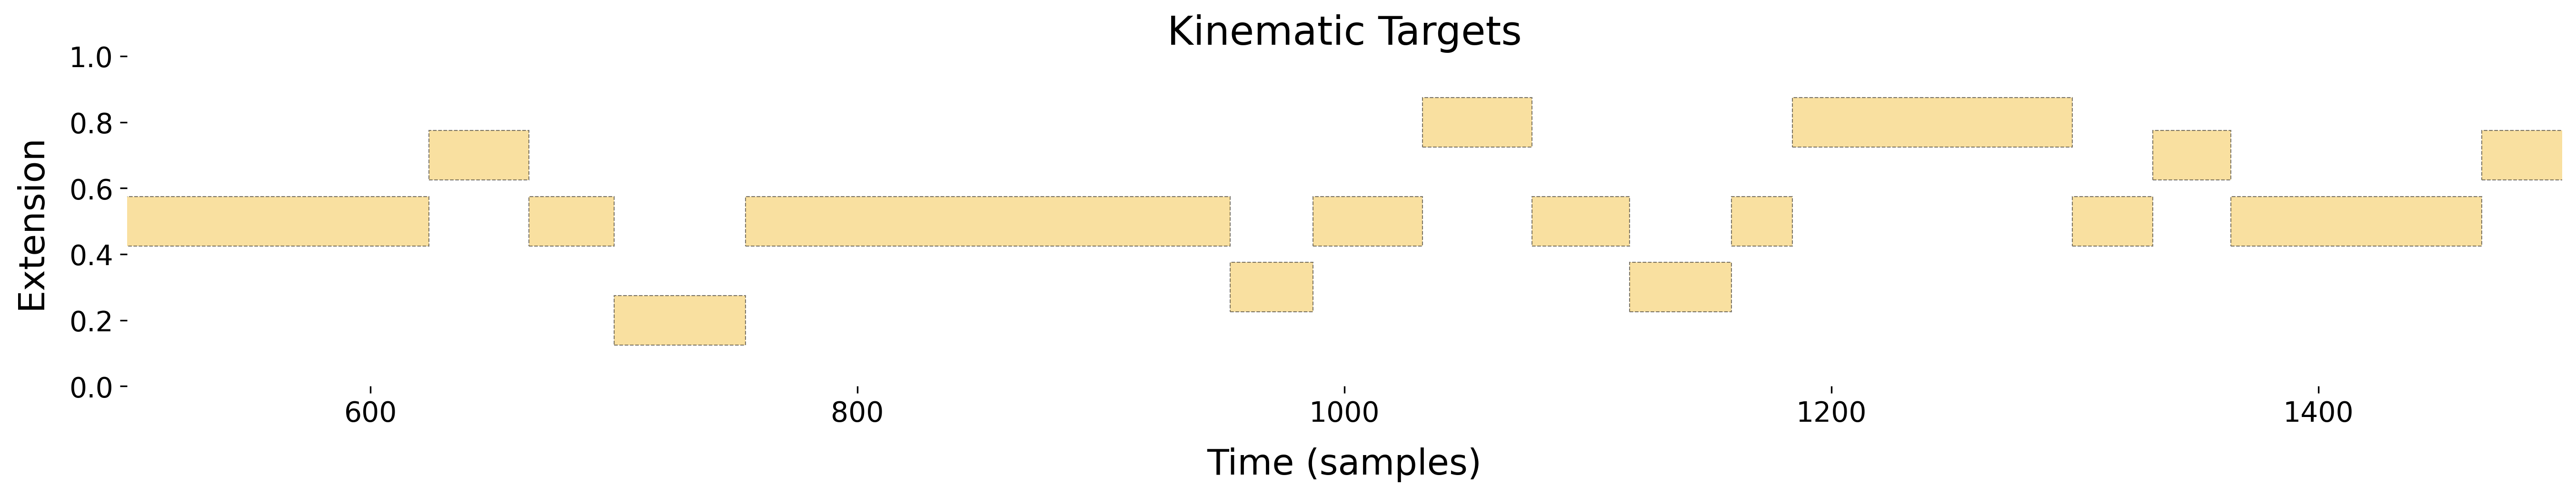

In [8]:
def plot_targets(targ, fing_color, targ_radius = 0.075, x_lim=(0,len(targ)),y_pred=None, plot_targ_TF=False):

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd

  # Find transitions in target display
  targ_starts = np.concatenate(([0], np.where(np.diff(targ) != 0)[0] + 1))

  # Compute the duration (W) of each target
  targ_durations = np.diff(np.append(targ_starts, len(targ)))  # Ensuring last target is included

  # Compute target heights
  # targ_half_height = targsize[targ_starts].flatten()  # Select correct column
  targ_height = 2 * targ_radius  # Full height = 2 * R
  targ_locs = targ[targ_starts] - targ_radius  # Compute Y positions

  # Plot the targets as rectangles
  fig, ax = plt.subplots(figsize=(22, 3), dpi=300)
  if plot_targ_TF:
    ax.plot(range(len(targ)), targ, 'k', linewidth=0.5, linestyle='-', zorder=1)  # Plot the target trajectory

  # Draw rectangles
  for i in range(len(targ_starts)):
      rect = plt.Rectangle((targ_starts[i], targ_locs[i]),
                          targ_durations[i], targ_height,
                          edgecolor='k', facecolor=fing_color['target'],
                          alpha=0.5, linestyle='--', linewidth=0.5, zorder=2)
      ax.add_patch(rect)

  if y_pred is not None:
    ax.plot(range(len(y_pred)), y_pred, fing_color['line'], linewidth=2, linestyle='-', zorder=3)  # Plot the target trajectory

  ax.spines[:].set_visible(False)

  ax.set_xlim(x_lim[0], x_lim[-1])

  # Configure plot
  ax.set_xlabel('Time (samples)',fontsize=18,labelpad=10)
  ax.set_ylabel('Extension',fontsize=18,labelpad=10)
  ax.set_title('Kinematic Targets',fontsize=20)
  ax.tick_params(axis='both', which='major', labelsize=14)
  ax.grid(False)
  plt.show()

fing = 1  # select finger to plot
if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ[:, fing], targ_radius=targsize.mean(), fing_color = fing_color, x_lim=(500,1500), plot_targ_TF=False)


In [9]:
targsize.mean()

np.float32(0.075)

# Standard Kalman Filter

---



Format Input (neural data)

In [10]:
# matrix of neural features for all electrodes over time
X_kf = neural_data


Format Output (kinematic target data) to Include Position & Acceleration

In [12]:
import numpy as np

def extend_kinematics_from_position(targ_pos_binned, bin_width, compute='velocity'):
    """
    Extends target position data to include velocity and/or acceleration.

    Parameters:
    -----------
    targ_pos_binned : np.ndarray
        Array of shape [t, d], where t is time and d is the number of spatial dimensions.
    bin_width : float
        Time interval between consecutive position samples.
    compute : str
        One of {'velocity', 'acceleration', 'both'} indicating which kinematics to compute.

    Returns:
    --------
    y_kf : np.ndarray
        Extended array of shape [t, d*k], where k = 1 (position + one of velocity/acceleration)
        or k = 2 (position + velocity + acceleration), ordered as [position, velocity, acceleration].
    """
    if compute not in ['velocity', 'acceleration', 'both']:
        raise ValueError("compute must be one of {'velocity', 'acceleration', 'both'}")

    # Check dimensionality
    if targ_pos_binned.ndim == 1:
        # If 1D, reshape to 2D with single spatial dimension
        targ_pos_binned = targ_pos_binned.reshape(-1, 1)

    t, d = targ_pos_binned.shape
    vel = acc = None

    if compute in ['velocity', 'both']:
        vel = np.diff(targ_pos_binned, axis=0) / bin_width
        vel = np.vstack((vel, vel[-1]))  # Keep same length by repeating last row

    if compute in ['acceleration', 'both']:
        if vel is None:
            vel_temp = np.diff(targ_pos_binned, axis=0) / bin_width
            vel_temp = np.vstack((vel_temp, vel_temp[-1]))
        else:
            vel_temp = vel
        acc = np.diff(vel_temp, axis=0) / bin_width
        acc = np.vstack((acc, acc[-1]))

    # Stack based on compute flag
    components = [targ_pos_binned]
    if compute == 'velocity':
        components.append(vel)
    elif compute == 'acceleration':
        components.append(acc)
    elif compute == 'both':
        components.extend([vel, acc])

    y_kf = np.hstack(components)
    return y_kf

y_kf = targ

bin_width = 0.032 # bin width in sec (useful for computing position from velocity data)
targ_pos_binned = targ

y_kf = extend_kinematics_from_position(targ_pos_binned = targ_pos_binned,
                                       bin_width       = bin_width,
                                       compute         = 'velocity') # velocity


In [135]:
y_feedback = targ_feedback

Train-test split

In [193]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_kf_train, X_kf_test, y_kf_train, y_kf_test, y_feedback_train, y_feedback_test, = train_test_split(X_kf, y_kf, y_feedback, test_size=0.15, shuffle=False, random_state=42)


Optimize Kalman Parameters

---



In [233]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm  # Import tqdm for progress bar

# Define the parameter grid to search
param_grid = {
    'C': np.arange(0.5, 4, 0.1),  # Values for C
    'O': [1]      # Values for O np.arange(1, 5, 1)
}

# Create a list to store results
results = []

# Iterate through the parameter combinations with progress bar
for params in tqdm(ParameterGrid(param_grid), desc="Optimizing Kalman Filter"):
    # Initialize and train the Kalman Filter
    model_kf = KalmanFilter(C=params['C'], O=params['O'])
    model_kf.fit(X_kf_train, y_kf_train)

    # Make predictions on the test set
    y_pred_kf_test = model_kf.predict(X_kf_test)

    # Calculate R² score
    r2   = r2_score(y_kf_test, y_pred_kf_test, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_kf_test, y_pred_kf_test, multioutput='raw_values'))

    # Store the results
    results.append({
        'C': params['C'],
        'O': params['O'],
        'R²_fing1': r2[0],
        'R²_fing2': r2[1],
        'R²': np.mean(r2[:2]),
        'RMSE_fing1': rmse[0],
        'RMSE_fing2': rmse[1],
        'RMSE': np.mean(rmse[:2])
    })

# Find the best parameters
best_params = min(results, key=lambda x: x['RMSE'])


Optimizing Kalman Filter: 100%|██████████| 35/35 [06:36<00:00, 11.33s/it]


In [234]:
# Print parameter tuning results
print("Best parameters:\n")
print("-------------------")
[print(f"{key}: {best_params[key]:.4f}") for key in best_params]


Best parameters:

-------------------
C: 3.5000
O: 1.0000
R²_fing1: 0.3956
R²_fing2: 0.5900
R²: 0.4928
RMSE_fing1: 0.1717
RMSE_fing2: 0.1449
RMSE: 0.1583


[None, None, None, None, None, None, None, None]

In [236]:
import pandas as pd

tuning_results = pd.DataFrame(results)
tuning_results.sort_values(by='R²', ascending=False, inplace=True)
tuning_results.head(20)
# tuning_results.reset_index(drop=True, inplace=True)

,C,O,R²_fing1,R²_fing2,R²,RMSE_fing1,RMSE_fing2,RMSE
30,3.5,1,0.395599,0.589955,0.492777,0.171734,0.144863,0.158299
29,3.4,1,0.395856,0.589655,0.492755,0.171698,0.144916,0.158307
31,3.6,1,0.395274,0.590161,0.492718,0.171780,0.144826,0.158303
28,3.3,1,0.396039,0.589252,0.492645,0.171672,0.144987,0.158329
32,3.7,1,0.394887,0.590279,0.492583,0.171835,0.144806,0.158320
27,3.2,1,0.396139,0.588739,0.492439,0.171658,0.145078,0.158368
33,3.8,1,0.394444,0.590317,0.492380,0.171898,0.144799,0.158349
26,3.1,1,0.396148,0.588105,0.492127,0.171656,0.145189,0.158423
34,3.9,1,0.393949,0.590279,0.492114,0.171968,0.144806,0.158387
25,3.0,1,0.396058,0.587340,0.491699,0.171669,0.145324,0.158497


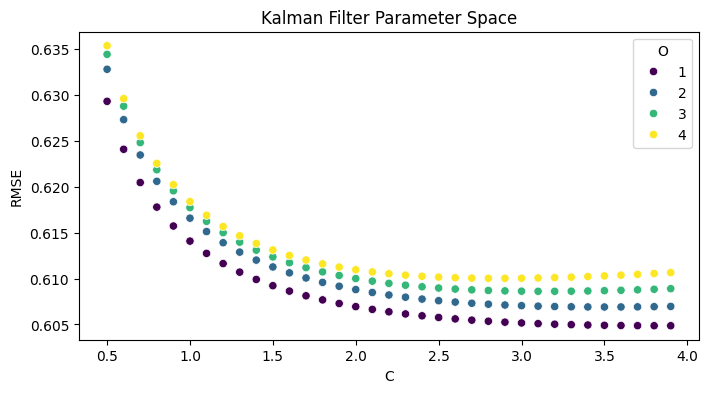

In [218]:
# tuning_results.plot(x='C', y='RMSE', kind='scatter', hue='O')
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.scatterplot(x='C', y='RMSE', hue='O', palette='viridis', data=tuning_results)

# sns.lineplot(x='C', y='R²_fing1', hue='O', palette='viridis', data=tuning_results)
# sns.lineplot(x='C', y='R²_fing2:', hue='O', palette='viridis', data=tuning_results)

plt.title('Kalman Filter Parameter Space')
plt.show()


Run Kalman Filter

---



In [346]:
# Initialize filter
model_kf = KalmanFilter(C=1.75, O=1) # Kalman filter with precomputed initial state. (Initial state computed during training)
# C controls the smoothing: larger values = more smoothing of the (target) predictions

# Fit model
model_kf.fit(X_kf_train,y_kf_train)

y_pred_kf_train = model_kf.predict(X_kf_train)
y_pred_kf_test  = model_kf.predict(X_kf_test)


Kalman Filter Electrode Weights

---



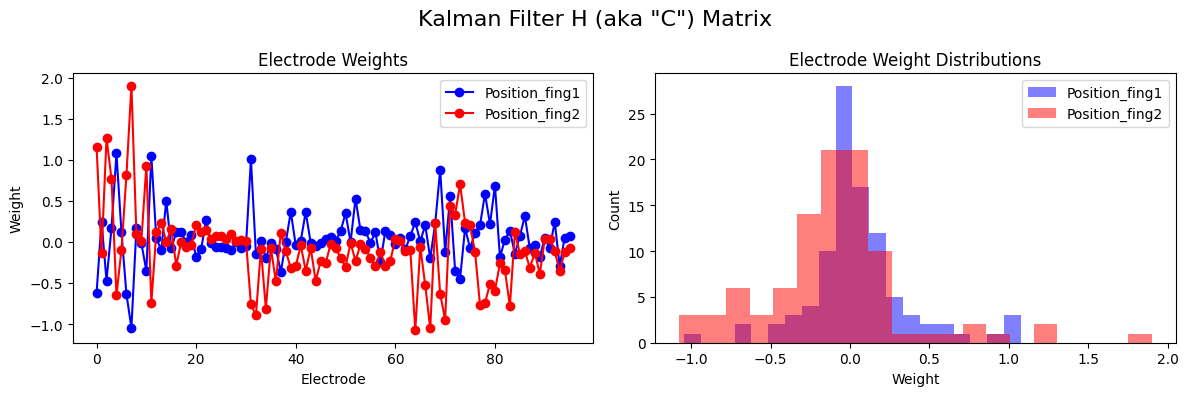

In [337]:
# H represents the transformation that converts kinematics to neural features
H = model_kf.model['H'] # N x 4 for N electrodes [pos_1, pos_2, vel_1, vel_2]

fig, axes = plt.subplots(1,2, figsize=(12, 4))

axes[0].plot(H[:, 0], marker='o', linestyle='-', color='b', label='Position_fing1')
axes[0].plot(H[:, 1], marker='o', linestyle='-', color='r', label='Position_fing2')
axes[0].set_title('Electrode Weights')
axes[0].set_xlabel('Electrode')
axes[0].set_ylabel('Weight')
axes[0].legend()
axes[0].grid(False)

axes[1].hist(H[:, 0], bins=20, color='b', alpha=0.5, label='Position_fing1')
axes[1].hist(H[:, 1], bins=20, color='r', alpha=0.5, label='Position_fing2')
axes[1].set_title('Electrode Weight Distributions')
axes[1].set_xlabel('Weight')
axes[1].set_ylabel('Count')
axes[1].legend()
axes[1].grid(False)

plt.suptitle('Kalman Filter H (aka "C") Matrix', fontsize=16)
plt.tight_layout()
plt.show()


In [345]:
W_thresh = 0.5
best_chans = np.where((np.abs(H[:, 0]) >= W_thresh) | (np.abs(H[:, 1]) >= W_thresh))[0]
best_chans


array([ 0,  2,  3,  4,  6,  7, 10, 11, 14, 31, 32, 34, 52, 64, 66, 67, 69,
       70, 71, 73, 77, 78, 79, 80, 83])

Run ReFIT Kalman

---



In [339]:
# ==== ReFIT Kalman Filter ====
# targets = ground truth target kinematics

# ---- ReFIT Kalman Filter ----
refit_kf = ReFITKalmanFilter(
    C=0.25,
    velocity_rot_method   = "rotate",  # options: "flip", "rotate"
    zero_vel_on_target_TF = True # This parameter doesn't seem too consequential. Just leave it at true
)

# Train using intention-aligned velocities
refit_kf.fit(X_kf_train, y_feedback_train, targets = y_kf_train, targsize=0.075)

# Predict on test neural data
y_pred_kf_train = refit_kf.predict(X_kf_train)
y_pred_kf_test  = refit_kf.predict(X_kf_test)


Evaluate model performance

---



In [403]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_kf_train, y_pred_kf_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_kf_test, y_pred_kf_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_kf_train, y_pred_kf_train, multioutput='raw_values') # 1 x 6 (pos_1, pos_2, vel_1, vel_2, acc_1, acc_2)
test_r2_list    = r2_score(y_kf_test, y_pred_kf_test, multioutput='raw_values')

from IPython.display import clear_output
# clear_output()

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1362
Train R²: 0.4322
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1501
Test R²: 0.5596


Plot Offline Target Predictions

---



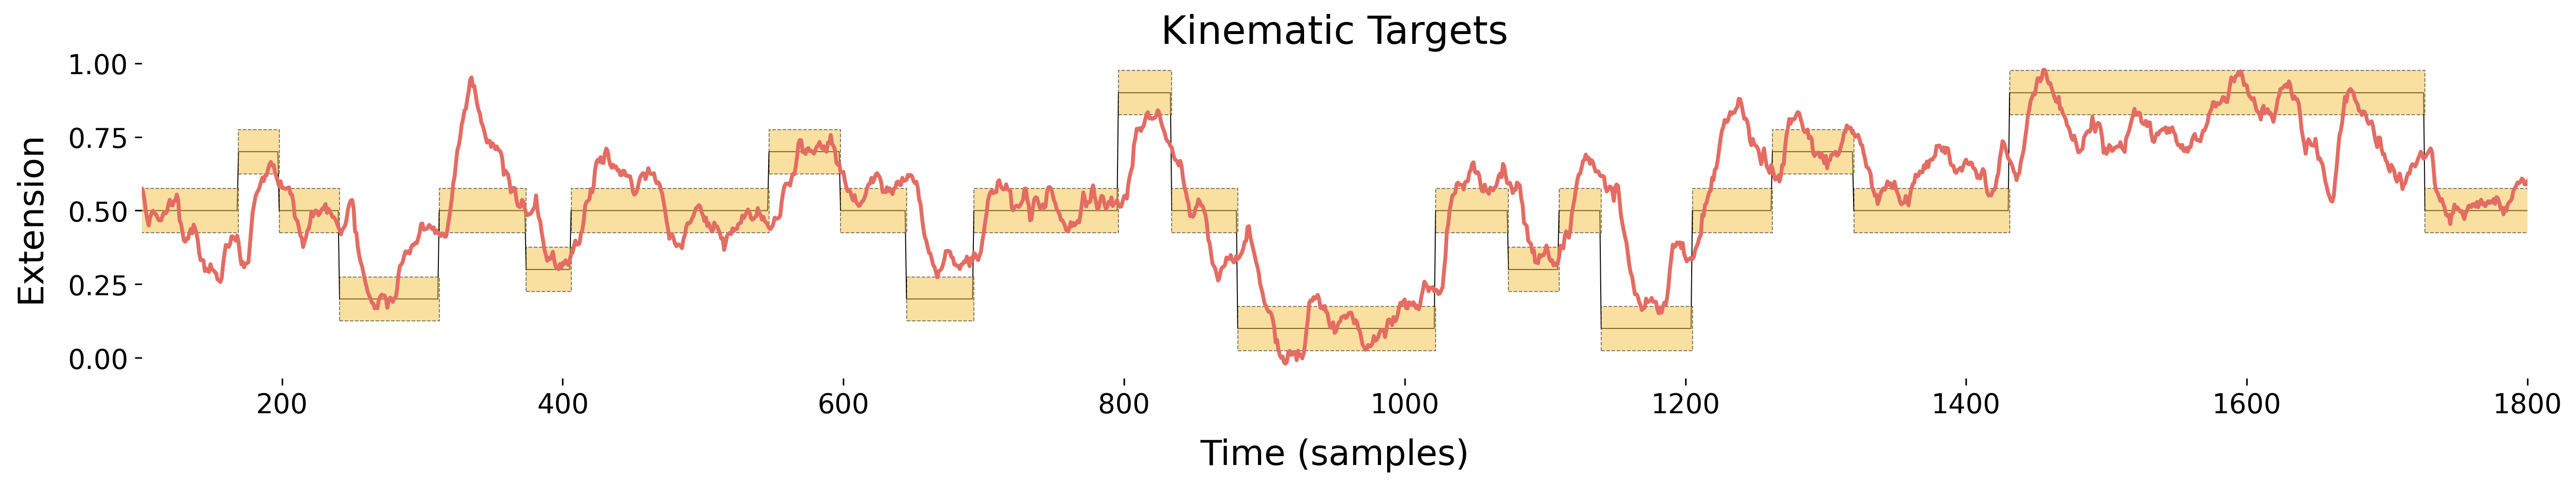


Offline R²: 0.5596


In [348]:
fing = 1 # select finger to plot
targ_vel      = y_kf_test[:,fing]
targ_vel_pred = y_pred_kf_test[:,fing]
# y_kf_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2, acc_1, acc_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
             x_lim        = (100,1800),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


Plot Online Target Predictions

---



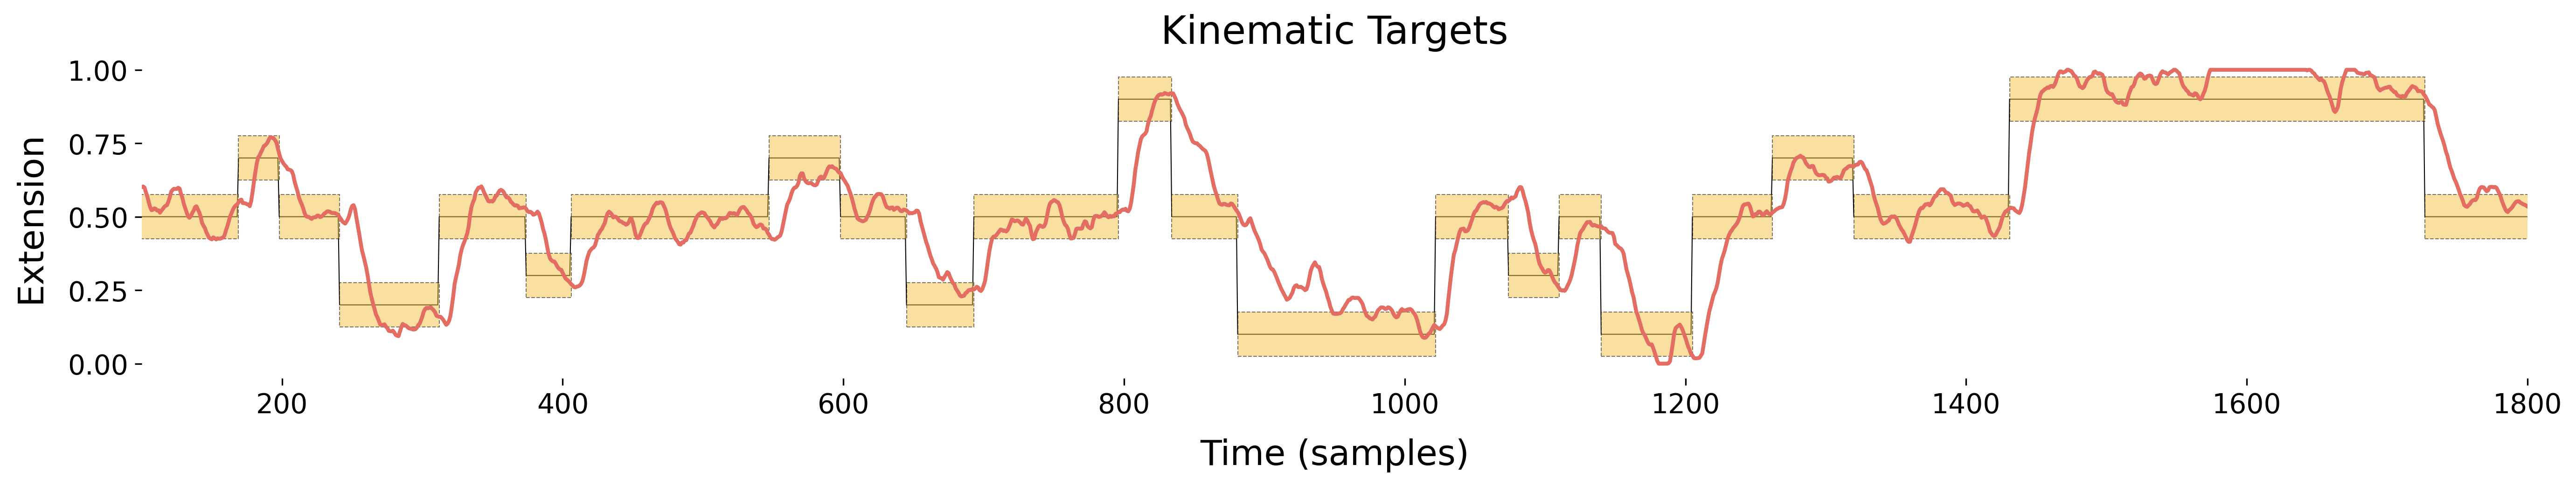


Online R²: 0.6438


In [247]:
fing = 1 # select finger to plot

targ_vel      = y_kf_test[:,fing]
targ_vel_pred = y_feedback_test[:,fing]
# targ_feedback is time_bins x 4 (pos_1, pos_2, vel_1, vel_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
             x_lim        = (100,1800),
             plot_targ_TF = True)

print(f"\nOnline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


# FeedForward Neural Network

---



In [494]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_train, X_test, y_train, y_test = train_test_split(neural_data, targ, test_size=0.15, shuffle=False, random_state=42)


In [495]:
#Declare model
model_ffn = FeedForwardNNDecoder(units      = [128,128,128],
                                 dropout    = 0.3,
                                 batch_size = 256,
                                 num_epochs = 150,
                                 verbose    = 1)

#Fit model
num_bins_before = 3
model_ffn.fit(X_train, y_train, num_bins_before = num_bins_before)

y_train = y_train[num_bins_before:,:]
y_test  = y_test[num_bins_before:,:]

#Get predictions
y_pred_train = model_ffn.predict(X_train)
y_pred_test  = model_ffn.predict(X_test)

from IPython.display import clear_output
clear_output()


Evaluate model performance

---



In [496]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_train, y_pred_train, multioutput='raw_values') # 1 x 4 (pos_1, pos_2, vel_1, vel_2)
test_r2_list    = r2_score(y_test, y_pred_test, multioutput='raw_values')

from IPython.display import clear_output
# clear_output()

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1374
Train R²: 0.4219
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1832
Test R²: 0.3452


Plot Offline Target Predictions

---



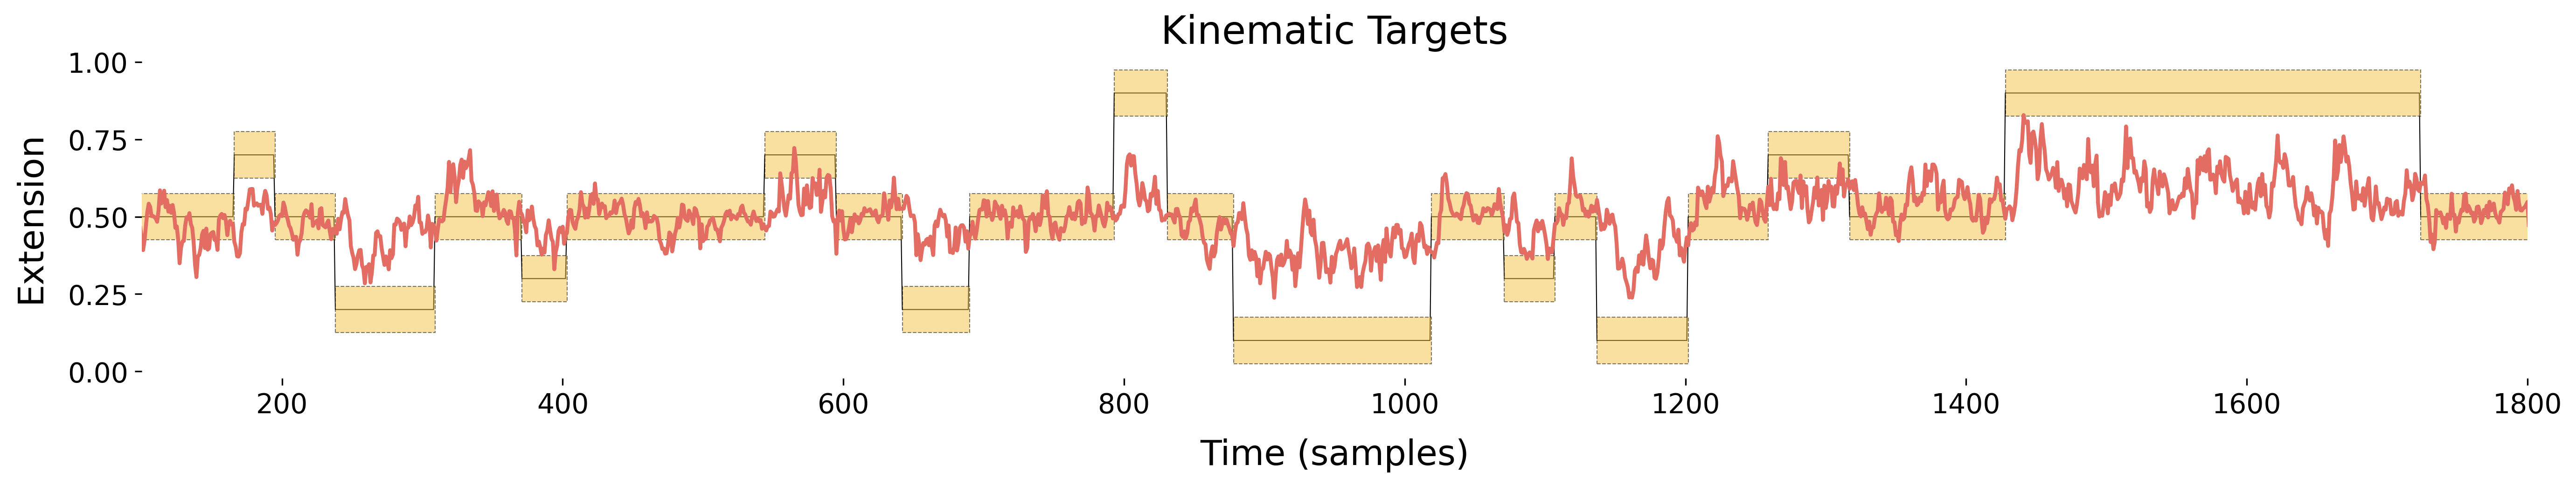


Offline R²: 0.3452


In [497]:
fing = 1 # select finger to plot
targ_vel      = y_test[:,fing]
targ_vel_pred = y_pred_test[:,fing]
# y_kf_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2, acc_1, acc_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
             x_lim        = (100,1800),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")
